# Method analysis
In this notebook, we setup a comprehensive analysis and comparison for multiple methods of identification, tracking-matching and nowcasting

## 0. Load the data

100%|██████████| 50/50 [00:24<00:00,  2.02it/s]


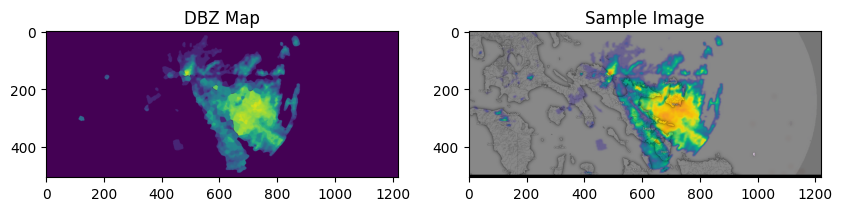

In [ ]:
import matplotlib.pyplot as plt
import cv2
import numpy as np
import os
import warnings
from tqdm import tqdm

warnings.filterwarnings('ignore')

from src.preprocessing import read_image, windy_preprocessing_pipeline, convert_contours_to_polygons
from src.cores.base import StormObject, StormsMap

# Load images
SOURCE_PATH = "data/images/philippines_13.269_123.832"

img_paths = [os.path.join(SOURCE_PATH, img_name) for img_name in sorted(os.listdir(SOURCE_PATH)) if img_name.endswith('.png')][:50]
dbz_maps = [windy_preprocessing_pipeline(read_image(img)) for img in tqdm(img_paths)]

sample_img = read_image(img_paths[0])
dbz_map = windy_preprocessing_pipeline(sample_img)

plt.figure(figsize=(10, 10))

plt.subplot(1, 2, 1)
plt.imshow(dbz_map)
plt.title('DBZ Map')

plt.subplot(1, 2, 2)
plt.imshow(sample_img)
plt.title('Sample Image')
plt.show()

## 1. Comparison of identification methods

**Basic idea:** Compare change in number of storms detected over time and give an insight view about each identification methods. Intuition:
- Low number of detected storm: can not distiguished between isolated storms and can led to poor modeling of splitting and merging.
- High number of detect storm: identify contiguous convective region with same characteristic as multiple isolated storms, can led to poor modeling of storm appearance and decay.

First, we use chart to visualize the change in number of detected convective cells over time.

### a) Simple contour identification

In [6]:
from src.identification import SimpleContourIdentifier

DBZ_THRESHOLD = 35  # dBZ threshold for storm identification
FILTER_AREA = 50

identifier = SimpleContourIdentifier()
simple_contour_storms_maps = []

for time_idx, dbz_map in tqdm(list(enumerate(dbz_maps)), desc="Identifying storms using Simple Contour Method"):
    contours = identifier.identify_storm(
        dbz_map,
        threshold=DBZ_THRESHOLD,
        filter_area=FILTER_AREA
    )
    polygons = [pol for pol in convert_contours_to_polygons(contours) if pol.area >= FILTER_AREA]
    polygons = sorted(polygons, key=lambda x: x.area, reverse=True)
    
    storms_map = StormsMap(
        time_frame=time_idx,
        storms=[StormObject(contour=pol, id=f"time_{time_idx}_storm_{i}") for i, pol in enumerate(polygons)]
    )

    simple_contour_storms_maps.append(storms_map)

Identifying storms using Simple Contour Method: 100%|██████████| 50/50 [00:00<00:00, 1705.08it/s]


### b) Hypothess contour identification

In [7]:
from src.identification import HypothesisIdentifier

DBZ_THRESHOLD = 35  # dBZ threshold for storm identification
FILTER_AREA = 50
FILTER_CENTER = 10

identifier = HypothesisIdentifier()
hypothesis_contour_storms_maps = []

for time_idx, dbz_map in tqdm(list(enumerate(dbz_maps)), desc="Identifying storms using Hypothesis Method"):
    contours = identifier.identify_storm(
        dbz_map,
        threshold=DBZ_THRESHOLD,
        filter_area=FILTER_AREA,
        filter_center=FILTER_CENTER
    )
    polygons = [pol for pol in convert_contours_to_polygons(contours) if pol.area >= FILTER_AREA]
    polygons = sorted(polygons, key=lambda x: x.area, reverse=True)
    
    storms_map = StormsMap(
        time_frame=time_idx,
        storms=[StormObject(contour=pol, id=f"time_{time_idx}_storm_{i}") for i, pol in enumerate(polygons)]
    )

    hypothesis_contour_storms_maps.append(storms_map)

Identifying storms using Hypothesis Method: 100%|██████████| 50/50 [00:02<00:00, 17.20it/s]


### c) Morphology contour identification

In [8]:
from src.identification import MorphContourIdentifier

DBZ_THRESHOLD = 35  # dBZ threshold for storm identification
FILTER_AREA = 50
FILTER_CENTER = 10

identifier = MorphContourIdentifier()
morph_contour_storms_maps = []

for time_idx, dbz_map in tqdm(list(enumerate(dbz_maps)), desc="Identifying storms using Morphology Method"):
    contours = identifier.identify_storm(
        dbz_map,
        threshold=DBZ_THRESHOLD,
        filter_area=FILTER_AREA,
        center_filter=FILTER_CENTER,
        n_thresh=3
    )
    polygons = [pol for pol in convert_contours_to_polygons(contours) if pol.area >= FILTER_AREA]
    polygons = sorted(polygons, key=lambda x: x.area, reverse=True)
    
    storms_map = StormsMap(
        time_frame=time_idx,
        storms=[StormObject(contour=pol, id=f"time_{time_idx}_storm_{i}") for i, pol in enumerate(polygons)]
    )

    morph_contour_storms_maps.append(storms_map)

Identifying storms using Morphology Method: 100%|██████████| 50/50 [00:32<00:00,  1.52it/s]


### d) Cluster contour identification

In [12]:
from src.identification import ClusterIdentifier

DBZ_THRESHOLD = 35  # dBZ threshold for storm identification
FILTER_AREA = 50
FILTER_CENTER = 10

identifier = ClusterIdentifier()
cluster_contour_storms_maps = []

for time_idx, dbz_map in tqdm(list(enumerate(dbz_maps)), desc="Identifying storms using Clustering Method"):
    contours = identifier.identify_storm(
        dbz_map=dbz_map,
        thresholds=range(DBZ_THRESHOLD, DBZ_THRESHOLD + 15, 5),
        filter_area=FILTER_AREA,
        filter_center=FILTER_CENTER
    )
    polygons = [pol for pol in convert_contours_to_polygons(contours) if pol.area >= FILTER_AREA]
    polygons = sorted(polygons, key=lambda x: x.area, reverse=True)
    
    storms_map = StormsMap(
        time_frame=time_idx,
        storms=[StormObject(contour=pol, id=f"time_{time_idx}_storm_{i}") for i, pol in enumerate(polygons)]
    )

    cluster_contour_storms_maps.append(storms_map)

Identifying storms using Clustering Method: 100%|██████████| 50/50 [00:28<00:00,  1.74it/s]


## Summary number of detected storms

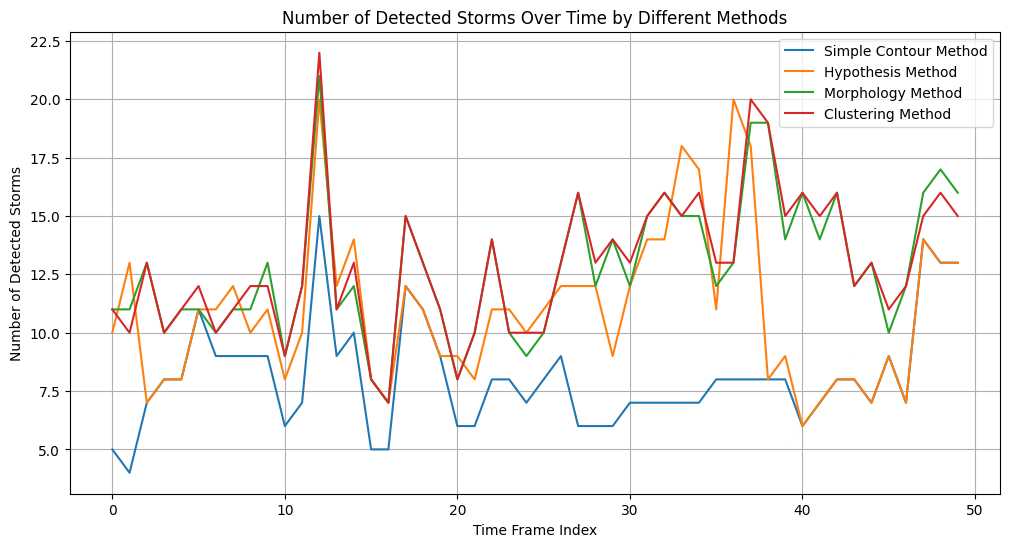

In [14]:
import matplotlib.pyplot as plt

methods_names = [
    "Simple Contour Method",
    "Hypothesis Method",
    "Morphology Method",
    "Clustering Method"
]

number_of_storms_detected = [
    [len(storms_map.storms) for storms_map in simple_contour_storms_maps],
    [len(storms_map.storms) for storms_map in hypothesis_contour_storms_maps],
    [len(storms_map.storms) for storms_map in morph_contour_storms_maps],
    [len(storms_map.storms) for storms_map in cluster_contour_storms_maps],
]

# Plotting
plt.figure(figsize=(12, 6))
for method_name, storms_counts in zip(methods_names, number_of_storms_detected):
    plt.plot(storms_counts, label=method_name)
plt.title('Number of Detected Storms Over Time by Different Methods')
plt.xlabel('Time Frame Index')
plt.ylabel('Number of Detected Storms')
plt.legend()
plt.grid()
plt.show()